In [25]:
import h5py
import os

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from tqdm import tqdm

import sys
sys.path.insert(0, "../scripts/")

from statfenics.utils import build_observation_operator
from swe_filter import ShallowOneKalman, ShallowOneEx

fe.set_log_level(50)

In [26]:
def ds_from_output_file(output_file, field="u", var=False):
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    nx = checkpoint["/"].attrs["nx"]
    dt = checkpoint["/"].attrs["dt"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    control = dict(nx=nx, dt=dt, theta=0.6, simulation="immersed_bump")
    params = dict(nu=nu)
    stat_params = dict(rho_u=0., ell_u=0.,
                       rho_h=1., ell_h=1.,
                       hilbert_gp=True, k=1, k_init_u=1, k_init_h=1)
    for key in stat_params:
        stat_params.update({key: checkpoint["/"].attrs[key]})

    if linear:
        swe = ShallowOneKalman(control, params, stat_params, lr=True)
    else:
        swe = ShallowOneEx(control, params, stat_params, lr=True)

    x = swe.x_coords
    t = checkpoint["/t"][:]
    u_mean = checkpoint["/u_mean"][:]
    u_var = checkpoint["/u_var"][:]
    h_mean = checkpoint["/h_mean"][:]
    h_var = checkpoint["/h_var"][:]
    
    u_ds = xr.DataArray(data=u_mean[:, :, np.newaxis, np.newaxis],
                        coords=dict(t=t, x=x.flatten(), nu=np.array([nu]), k=np.array([k])),
                        name="u")
    h_ds = xr.DataArray(data=h_mean[:, :, np.newaxis, np.newaxis],
                        coords=dict(t=t, x=x.flatten(), nu=np.array([nu]), k=np.array([k])),
                        name="h")
    
    u_var_ds = xr.DataArray(data=u_var[:, :, np.newaxis, np.newaxis],
                            coords=dict(t=t, x=x.flatten(), nu=np.array([nu]), k=np.array([k])),
                            name="u_var")
    h_var_ds = xr.DataArray(data=h_var[:, :, np.newaxis, np.newaxis],
                            coords=dict(t=t, x=x.flatten(), nu=np.array([nu]), k=np.array([k])),
                            name="h_var")
    
    return xr.merge([u_ds, h_ds, u_var_ds, h_var_ds])


def errors_from_output_file(output_file, field="u", var=False):
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    t_obs = checkpoint["/t_obs"][:]
    rmse = checkpoint["/rmse"][:]
    lml = checkpoint["/lml"][:]
    
    rmse_ds = xr.DataArray(data=rmse[:, np.newaxis, np.newaxis],
                           coords=dict(t=t_obs, nu=np.array([nu]), k=np.array([k])),
                           name="rmse")
    lml_ds = xr.DataArray(data=lml[:, np.newaxis, np.newaxis],
                          coords=dict(t=t_obs, nu=np.array([nu]), k=np.array([k])),
                          name="lml")
    return xr.merge([rmse_ds, lml_ds])

In [27]:
# read in all outputs from `output_dir`
import glob
output_dir = "../outputs/swe-bump/nonlinear-filter-*.h5"
nonlinear_output_files = glob.glob(output_dir)

state_ds = []
errors_ds = []
for output_file in nonlinear_output_files:
    state_ds.append(ds_from_output_file(output_file))
    errors_ds.append(errors_from_output_file(output_file))
 
state_ds = xr.merge(state_ds)
errors_ds = xr.merge(errors_ds)

In [28]:
y = xr.open_dataset("../data/h_bump.nc")

In [30]:
errors_ds

<xarray.Dataset>
Dimensions:  (t: 125, nu: 6, k: 5)
Coordinates:
  * t        (t) float64 0.01 0.05 0.09 0.13 0.17 ... 4.81 4.85 4.89 4.93 4.97
  * nu       (nu) float64 0.0 1e-06 0.0001 0.01 1.0 100.0
  * k        (k) int64 4 8 16 64 128
Data variables:
    rmse     (t, nu, k) float64 6.024e-05 6.022e-05 ... 0.0004734 0.0004734
    lml      (t, nu, k) float64 -1.151e+08 -1.151e+08 ... -7.111e+09 -7.111e+09

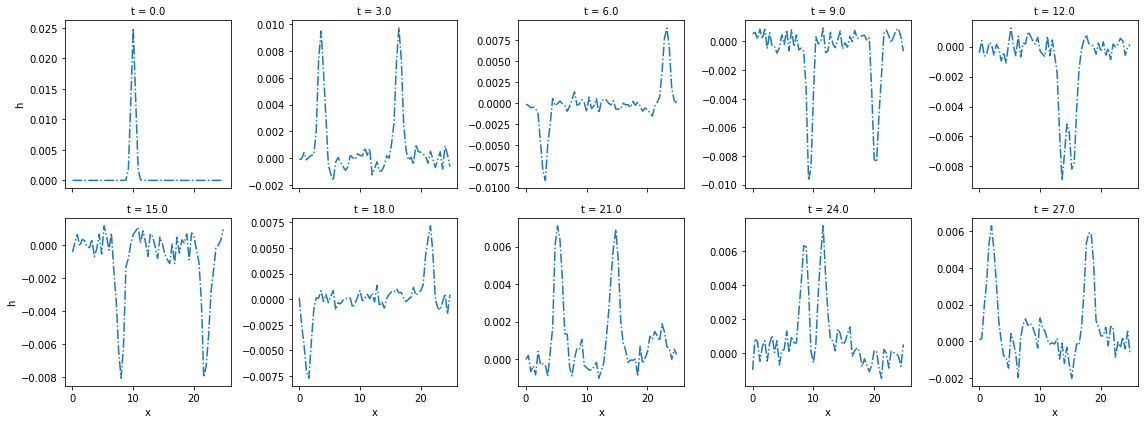

In [31]:
y_obs = y["h"].values[1:, ::8]
y.h.isel(x=slice(0, -1, 8), t=slice(0, 3000, 300)).plot(
    ls="-.", x="x", col="t", col_wrap=5, sharey="none")
plt.show()

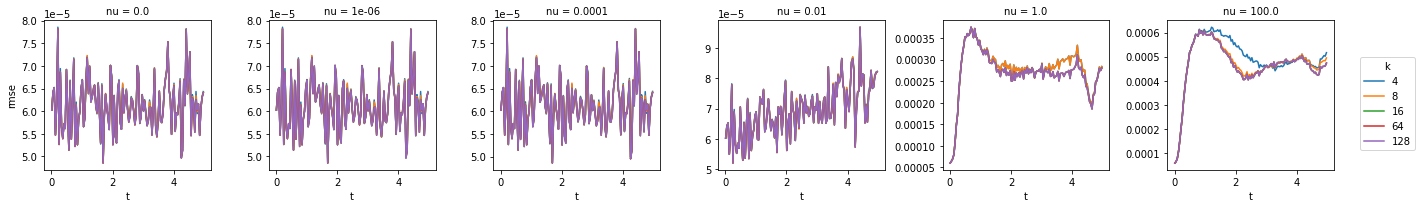

In [35]:
errors_ds.rmse.plot(
    x="t", hue="k", col="nu", col_wrap=6, sharey=False)
plt.show()

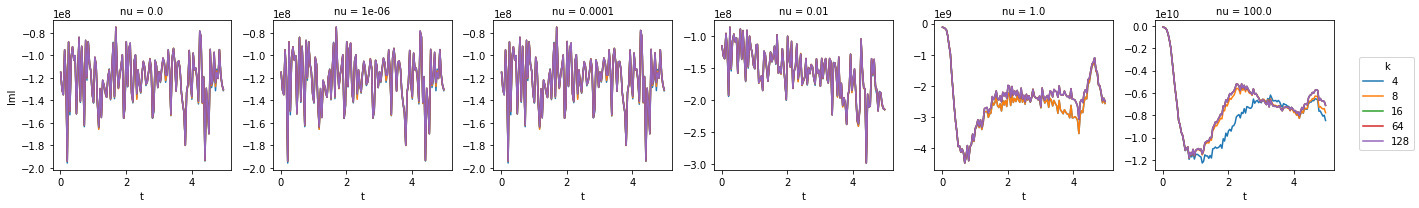

In [36]:
errors_ds.lml.plot(
    x="t", hue="k", col="nu", col_wrap=6, sharey=False)
plt.show()

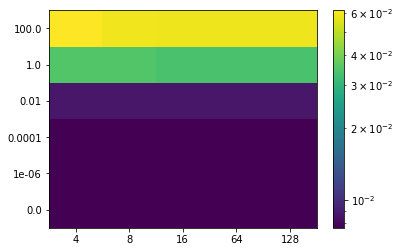

In [89]:
import matplotlib.colors as colors

rmse_array = errors_ds.sum(dim="t").rmse.to_numpy()

fig, ax = plt.subplots(1, 1)
im = ax.pcolormesh(range(len(rmse.coords["k"].to_numpy())), 
               range(len(rmse.coords["nu"].to_numpy())),
               rmse_array,
               norm=colors.LogNorm(vmin=rmse_array.min(), 
                                   vmax=rmse_array.max()))
ax.set_xticks(range(len(rmse.coords["k"].to_numpy())), 
              rmse.coords["k"].to_numpy())
ax.set_yticks(range(len(rmse.coords["nu"].to_numpy())), 
           rmse.coords["nu"].to_numpy())
# ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
plt.colorbar(im, ax=ax)
plt.show()

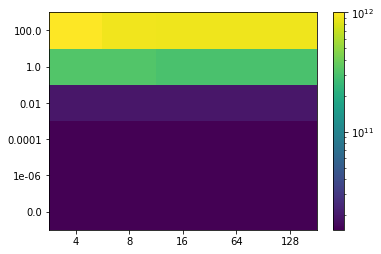

In [97]:
lml_array = -errors_ds.sum(dim="t").lml.to_numpy()

fig, ax = plt.subplots(1, 1)
im = ax.pcolormesh(range(len(errors_ds.coords["k"].to_numpy())), 
                   range(len(errors_ds.coords["nu"].to_numpy())),
                   lml_array,
                   norm=colors.LogNorm(vmin=lml_array.min(),
                                       vmax=lml_array.max()))
ax.set_xticks(range(len(errors_ds.coords["k"].to_numpy())), 
              rmse.coords["k"].to_numpy())
ax.set_yticks(range(len(rmse.coords["nu"].to_numpy())), 
           rmse.coords["nu"].to_numpy())
# ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
plt.colorbar(im, ax=ax)
plt.show()

In [ ]:
def vector_norm(x, dim, ord=None):
    return xr.apply_ufunc(np.linalg.norm, x,
                          input_core_dims=[[dim]],
                          kwargs={'ord': ord, 'axis': -1})